# SVM for Tiny Images - Raw Pixels as Features

## Initial Setup

In [2]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

import imageutils

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Tiny Images into a Matrix 

In [14]:
base_dir = 'tiny_images_32'
(X_all, y_all, classes, class_dict) = imageutils.load_data(base_dir)
image_height = X_all.shape[1]
image_width = X_all.shape[2]
print(X_all.shape)
print(classes)

(1360, 32, 32, 3)
['bluebell', 'buttercup', 'colts_foot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lily_valley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


## Reshape the matrix so that each row is an entire image

In [15]:
# Flatten the data so that each row in X_all_rows represents an image
X_all_rows = np.reshape(X_all, (X_all.shape[0], -1))
print(X_all_rows.shape)

(1360, 3072)


## Randomly Shuffle the Images

In [16]:
# Randomly shuffle the input images and labels (IN THE SAME RANDOM ORDER SO THEY ARE STILL CORRELATED)
rng_state = np.random.get_state()
np.random.shuffle(X_all_rows)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

## Split the Data into Train/Test Segments

In [17]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all_rows, y_all, test_size=0.2)
print("Num training: {0}".format(X_train.shape[0]))
print("Num testing: {0}".format(X_test.shape[0]))

Num training: 1020
Num testing: 340


In [18]:
# 20% of training data reserved for the validation set
# Here we're using a fixed validation set, not doing cross-validation
percentage_validation = 0.20

num_total = X_train.shape[0]
num_validation = int(num_total * percentage_validation)
print("Num validation = {0}".format(num_validation))
num_training = num_total - num_validation

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

Num validation = 204


# Image Preprocessing

[ 84.31740196  93.04901961  68.94607843  84.52818627  93.08823529
  68.73897059  85.93627451  93.97426471  69.68995098  88.13848039]


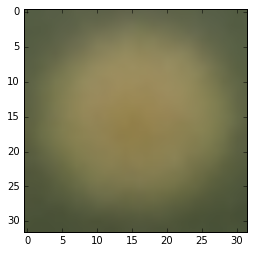

In [19]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [20]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [21]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape

(816, 3073) (204, 3073) (340, 3073)


## Train a Linear SVM on the Normalized Pixel Values

In [23]:
from sklearn.svm import SVC
#from sklearn.cross_validation import cross_val_score

svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print('accuracy: %f' % (np.mean(y_pred == y_test)))

accuracy: 0.473529


## View Cross-Validation Accuracies with 10 Folds

In [24]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=False, random_state=None)

svm_cv_accuracies = cross_val_score(svm, X_train, y_train, cv=cv, n_jobs=7)
print(svm_cv_accuracies)

[ 0.41463415  0.43902439  0.51219512  0.51219512  0.41463415  0.41463415
  0.41975309  0.48148148  0.45679012  0.48148148]


In [12]:
svm_cv_accuracies.mean(), svm_cv_accuracies.std()

(0.091869918699186995, 0.018143568907114344)

## Try Grid Search to Find SVM Parameters

In [13]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

#clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=7)
clf = GridSearchCV(svm, param_grid, cv=cv, n_jobs=7)

clf = clf.fit(X_train, y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

Best estimator found by randomized hyper parameter search:
{'C': 1000.0, 'gamma': 0.0001}
Best parameters validation score: 0.091
